## Performing PCA with an Undercomplete Linear Autoencoder

In [2]:
import tensorflow as tf

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

2022-12-23 07:30:09.641752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 07:30:18.818472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# generate a 3D dataset
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [4]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 2ms/step


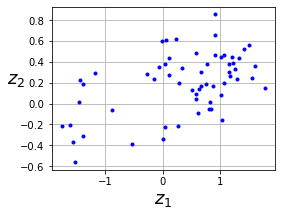

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

## Stacked Autoencoders

In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [7]:
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")
history = stacked_ae.fit(X_train, X_train, epochs=20,
                        validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 3ms/step - loss: 0.0248 - val_loss: 0.0189
Epoch 2/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0175 - val_loss: 0.0167
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0158 - val_loss: 0.0153
Epoch 4/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0145 - val_loss: 0.0145
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0141 - val_loss: 0.0141
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0139 - val_loss: 0.0139
Epoch 8/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0137 - val_loss: 0.0138
Epoch 9/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0135 - val_loss: 0.0136
Epoch 10/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.013

1/1 [==============================] - 0s 79ms/step


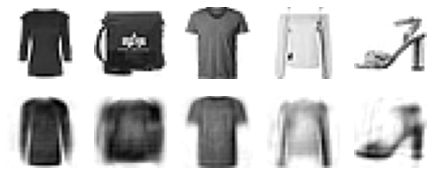

In [8]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")
        
plot_reconstructions(stacked_ae)
plt.show()

### Visualizing the Fashion MNist Dataset

In [9]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 1ms/step


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


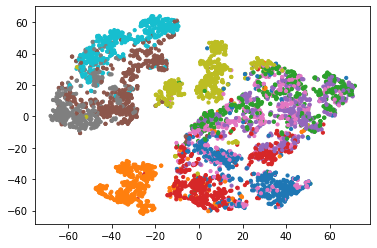

In [10]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:,1], c=y_valid, s=10, cmap="tab10")
plt.show()

### Tying the weights
When the stacked autoencoder is symmetrical, you can set the weights on the decoder to equal the weights of the encoder. This halves the number of parameters, speeding up training and reducing overfitting.

In [11]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                     shape=self.dense.input_shape[-1],
                                     initializer="zeros")
        super().build(batch_input_shape)
        
    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [12]:
dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

## Convolutional Autoencoders

In [13]:
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28,28,1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28,28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

## Denoising Autoencoders

In [14]:
dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

## Sparse Autoencoders

In [15]:
sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28,28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

In [18]:
kl_divergence = 0 #tf.keras.layers.kullback_leibler_divergence

class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target
    
    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activites) + 
            kl_divergence(1. -  self.target, 1. - mean_activities))

In [20]:
kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid",
                         activity_regularizer=kld_reg)
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28,28])
])
sparsel_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

## Variational Autoencoders

In [21]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs 
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [23]:
codings_size = 10

inputs = tf.keras.layers.Input(shape=[28,28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [29]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [30]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [32]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), 
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [34]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                            validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 5s 7ms/step - loss: 0.0513 - val_loss: 0.0394
Epoch 2/25
430/430 [==============================] - 3s 8ms/step - loss: 0.0377 - val_loss: 0.0365
Epoch 3/25
430/430 [==============================] - 4s 8ms/step - loss: 0.0355 - val_loss: 0.0348
Epoch 4/25
430/430 [==============================] - 4s 8ms/step - loss: 0.0344 - val_loss: 0.0345
Epoch 5/25
430/430 [==============================] - 3s 8ms/step - loss: 0.0338 - val_loss: 0.0346
Epoch 6/25
430/430 [==============================] - 3s 8ms/step - loss: 0.0333 - val_loss: 0.0336
Epoch 7/25
430/430 [==============================] - 3s 6ms/step - loss: 0.0329 - val_loss: 0.0330
Epoch 8/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0326 - val_loss: 0.0328
Epoch 9/25
430/430 [==============================] - 3s 8ms/step - loss: 0.0324 - val_loss: 0.0325
Epoch 10/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0321 - val_loss: 0.0334

## Generating Fashion MNist Images

In [35]:
codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

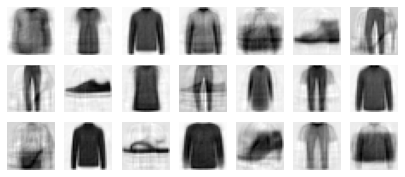

In [37]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
plt.show()

In [42]:
codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)
images = variational_decoder(codings).numpy()